In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import optimize, stats

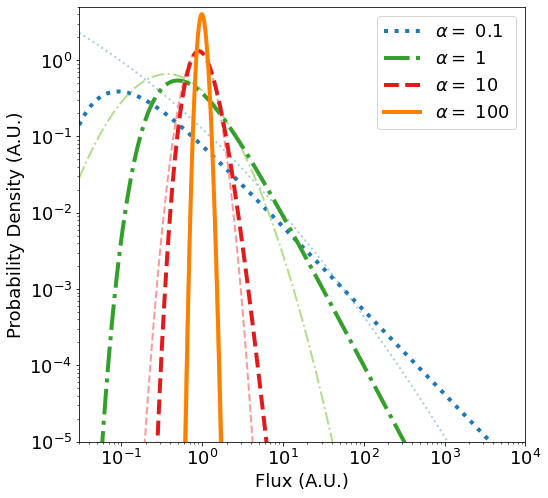

In [2]:
plot_alphas = [0.1, 1, 10, 100]
linestyles = [':', '-.', '--', '-']
xlim = [3e-2, 1e4]
ylim = [1e-5, 5e0]
xs = np.geomspace(xlim[0], xlim[1], num=1000)
fig, ax = plt.subplots(1, figsize=(8, 8))
cmap = plt.get_cmap('Paired')
ax.set_prop_cycle(color=cmap.colors)
for i, plot_alpha in enumerate(plot_alphas):
    plot_beta = plot_alpha
    ax.plot(xs, stats.lognorm.pdf(xs, 1/np.sqrt(plot_alpha), scale=plot_beta/plot_alpha),
            linestyle=linestyles[i], linewidth=2)
    ax.plot(xs, stats.invgamma.pdf(xs, plot_alpha, scale=plot_beta), linestyle=linestyles[i], linewidth=4,
            label=r"$\alpha =$ {}".format(plot_alpha))
ax.set_xlabel("Flux (A.U.)")
ax.set_ylabel("Probability Density (A.U.)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
plt.savefig('inverse_gamma.png')
plt.savefig('inverse_gamma.pdf')

[2.98314714] [0.73202108]


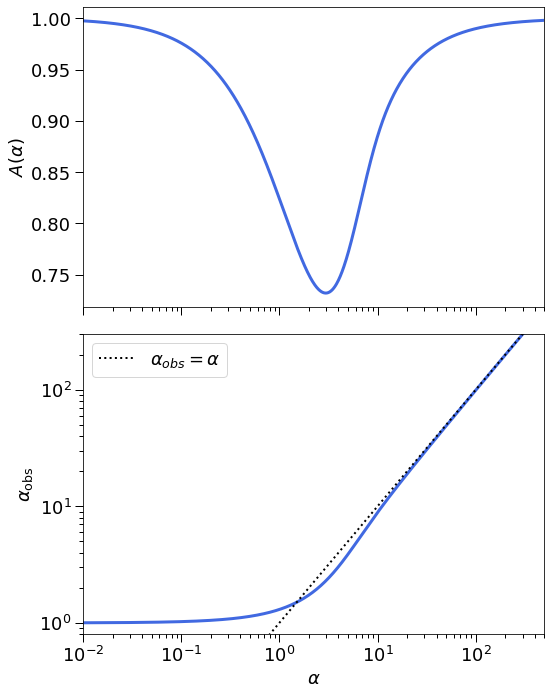

In [3]:
alphas = np.logspace(-2, 2.7, 1000)
ks = np.arange(1, 1500)[..., np.newaxis]
pmfs = stats.poisson.pmf(ks, alphas)
factors = np.sum(pmfs/ks, axis=0)*alphas/(1 - np.exp(-alphas))**2
factors = 1/factors
print(alphas[factors == np.min(factors)], factors[factors == np.min(factors)])
alpha_obs = alphas*factors/(1 - np.exp(-alphas))
fig, axes = plt.subplots(2, figsize=(8, 10), sharex=True)
axes[0].plot(alphas, factors, linewidth=3, color='royalblue')
axes[0].set_ylabel(r"$A(\alpha)$")
axes[1].plot(alphas, alpha_obs, linewidth=3, color='royalblue')
axes[1].plot(alphas[alphas > 0.1], alphas[alphas > 0.1], color='k', linestyle=':',
             linewidth=2, label=r"$\alpha_{obs} = \alpha$")
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_xlim([1e-2, 5e2])
axes[1].set_xscale('log')
axes[1].set_ylabel(r"$\alpha_{\mathrm{obs}}$")
axes[1].set_yscale('log')
axes[1].set_ylim([0.8, 3e2])
axes[1].legend()
for ax in axes:
    ax.tick_params(axis='both', which='major', length=8, width=1)
    ax.tick_params(axis='both', which='minor', length=4, width=1)
fig.tight_layout()
plt.savefig('alpha_obs.png')
plt.savefig('alpha_obs.pdf')

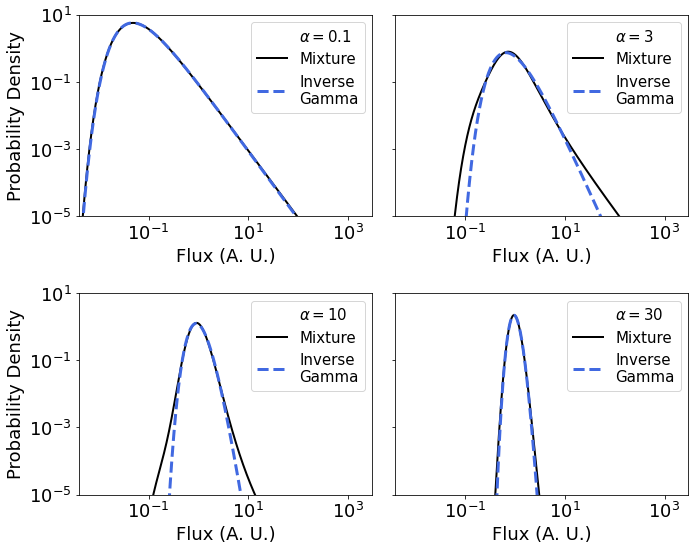

In [4]:
alphas = [0.1, 3, 10, 30]
ks = np.arange(1, 100)
fluxes = np.geomspace(1e-5, 1e5, 10000)
flux_lims = [[3e-4, 2e1], [3e-2, 2e2], [6e-1, 2e0]]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)
for ax, alpha in zip(axes.flat, alphas):
    ax.plot([], [], ' ', label=r"$\alpha = {}$".format(alpha))
    weights = stats.poisson.pmf(ks, alpha)/(1 - np.exp(-alpha))
    true_dist = np.zeros(len(fluxes))
    for k, weight in zip(ks, weights):
        true_dist += weight * fluxes**-2 * stats.gamma.pdf(1/fluxes, k, scale=1/(1 - np.exp(-alpha))/k)
    ax.plot(fluxes, true_dist, linewidth=2, linestyle='-', color='black',
            label="Mixture")
    
    A = (alpha/(1 - np.exp(-alpha))*np.sum(weights/ks))**-1
    alpha_obs = A*alpha/(1 - np.exp(-alpha))
    beta_obs = A*alpha # Let beta = alpha, phi = 0
    
    ax.plot(fluxes, stats.invgamma.pdf(fluxes, alpha_obs, scale=beta_obs),
            linewidth=3, linestyle='--', color='royalblue', label="Inverse\nGamma")
#     ax.plot(fluxes, stats.lognorm.pdf(fluxes, 1/np.sqrt(alpha_obs), scale=beta_obs/alpha_obs),
#             linewidth=3, linestyle=':', color='orange', label="Lognormal")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([4e-3, 3e3])
    ax.set_ylim([1e-5, 1e1])
    ax.set_xlabel("Flux (A. U.)")
    ax.legend(fontsize=15)
for i in range(2):
    axes[i, 0].set_ylabel("Probability Density")
fig.tight_layout()
plt.savefig('approximation.png')
plt.savefig('approximation.pdf')

In [5]:
# name, flare rate [s^-1], flare fluence [erg/cm^2], phi
sources = [['Loner Flare', 1e-7, 4e-2, 0.95],
           ['FSRQ', 5e-6, 8e-4, 0.95],
           ['Flaring BL Lac', 1e-5, 2e-5, 0.85],
           ['Constant BL Lac', 1e-4, 2e-5, 0.85]]

bin_duration = 7*86400 # s
num_samples = int(12*365*86400/bin_duration)
times = (bin_duration/365/86400)*np.array(range(num_samples), dtype=float)

lcs = []
params = []

for name, flare_rate, flare_fluence, phi in sources:

    alpha = flare_rate*bin_duration
    beta = flare_fluence*flare_rate*alpha

    seed = 34
    rng = np.random.default_rng(seed)

    p_zero = np.exp(-alpha)
    ks = np.arange(1, 10000)
    pmfs = stats.poisson.pmf(ks, alpha)
    obs_factor = alpha/(1 - p_zero)**2 * np.sum(pmfs/ks)
    alpha_obs = alpha/(1 - p_zero)/obs_factor
    beta_obs = (1 - phi)*beta/obs_factor
    p = (1 - phi)/(1 + phi/alpha*(1 - p_zero)*obs_factor)
    print(alpha, alpha_obs)
    print(beta, beta_obs)
    print(phi)

    samples = np.zeros(num_samples)
    prob_rvs = rng.random(num_samples)
    quantiles = rng.random(num_samples)
    gamma_rvs = rng.gamma(alpha_obs, scale=1/beta_obs, size=num_samples)
    if prob_rvs[0] < 1 - p_zero:
        samples[0] = gamma_rvs[0]
    for i in range(1, num_samples):
        if samples[i - 1] == 0:
            if prob_rvs[i] < p*(1 - p_zero):
                samples[i] = gamma_rvs[i]
        elif samples[i - 1] > 0:
            if prob_rvs[i] < 1 - p*p_zero:
                b = beta_obs/(1 - phi)
                samples[i] = rng.gamma(rng.poisson(phi*b*samples[i - 1]) + alpha_obs, scale=1/b)

    scale_flux = 1e-9 # erg cm^2 s^-1
    fluxes = samples.copy()
    fluxes[fluxes > 0] = 1/fluxes[fluxes > 0]/scale_flux
    lcs.append(fluxes)
    params.append([alpha_obs, beta_obs/scale_flux])

0.06048 1.0152989641596548
2.4192000000000003e-10 1.1917052284483394e-11
0.95
3.0240000000000005 2.3268410005892703
1.2096000000000003e-08 4.427483256634993e-10
0.95
6.048000000000001 4.858894637900779
1.2096000000000005e-09 1.4542245296117777e-10
0.85
60.480000000000004 59.46258072826523
1.2096000000000002e-07 1.7838774218479575e-08
0.85


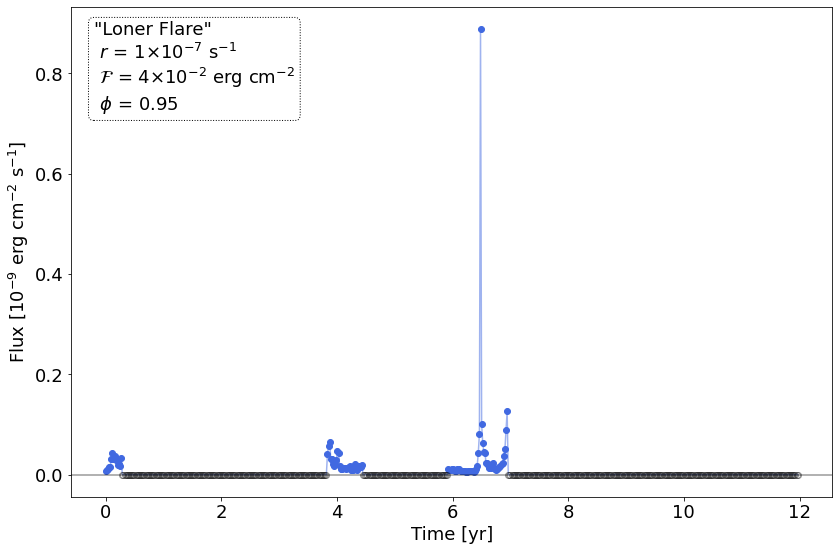

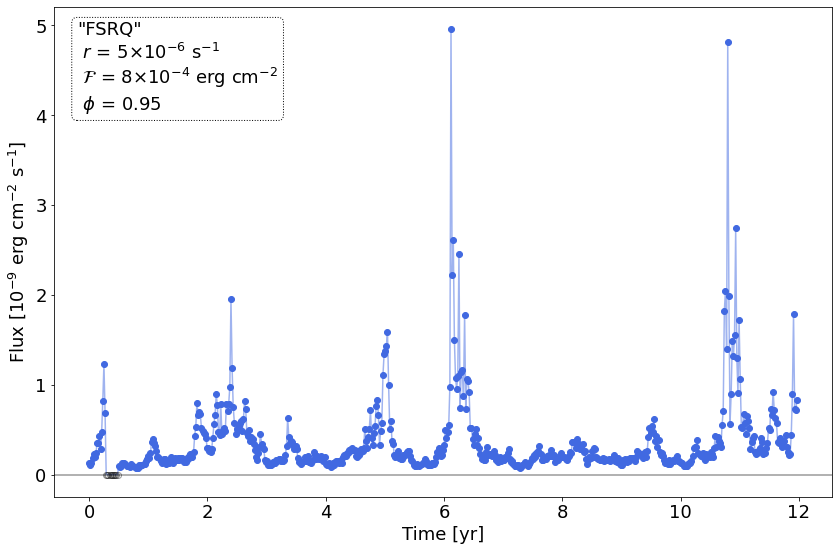

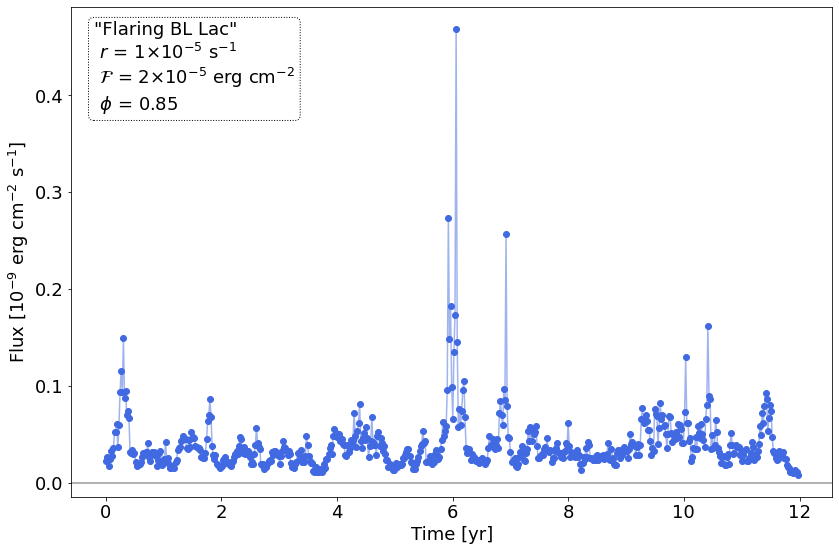

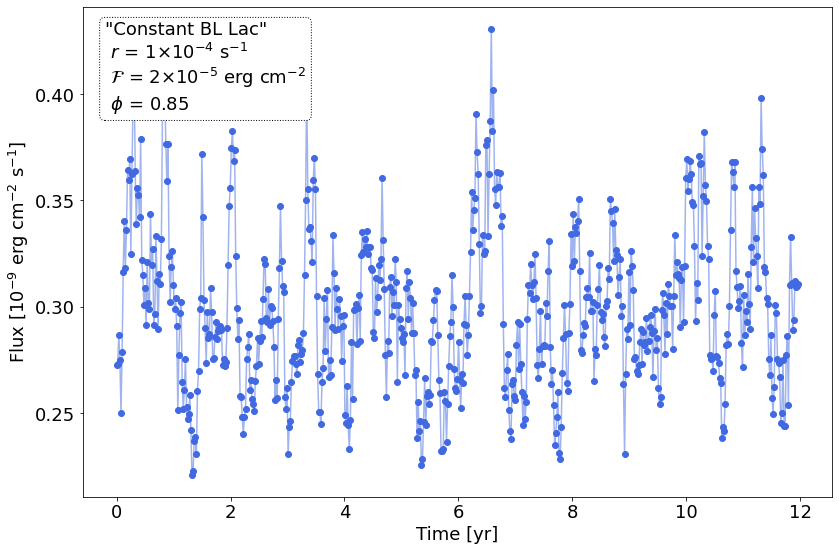

In [6]:
for (name, flare_rate, flare_fluence, phi), fluxes in zip(sources, lcs):
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(times, fluxes, linestyle='-', marker=None, alpha=0.5, color='royalblue')
    ax.plot(times[fluxes > 0], fluxes[fluxes > 0], linestyle='none', marker='o', color='royalblue')
    ax.plot(times[fluxes <= 0], fluxes[fluxes <= 0], linestyle='none', marker='o', color='black',
            fillstyle='none', alpha=0.4)
    if name != 'Constant BL Lac':
        ax.axhline(0, color='black', alpha=0.4)
    ax.set_xlabel("Time [yr]")
    ax.set_ylabel(r"Flux [$10^{-9}$ erg cm$^{-2}$ s$^{-1}$]")
    def pretty(var):
        return "$\\times 10^{{-".join("{:.00e}".format(var).split('e-0')) + "}}$"
    key = ("\"{}\"\n $r$ = {} s$^{{-1}}$\n $\mathcal{{F}}$ = {} erg cm$^{{-2}}$\n $\phi$ = {}"
           .format(name, pretty(flare_rate), pretty(flare_fluence), phi))
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', linestyle=':')
    ax.text(0.03, 0.875, key,
         horizontalalignment='left',
         verticalalignment='center',
         transform = ax.transAxes,
         bbox=props)
    fig.tight_layout()
    plt.savefig("simulated_{}.png".format(name))
    plt.savefig("simulated_{}.pdf".format(name))

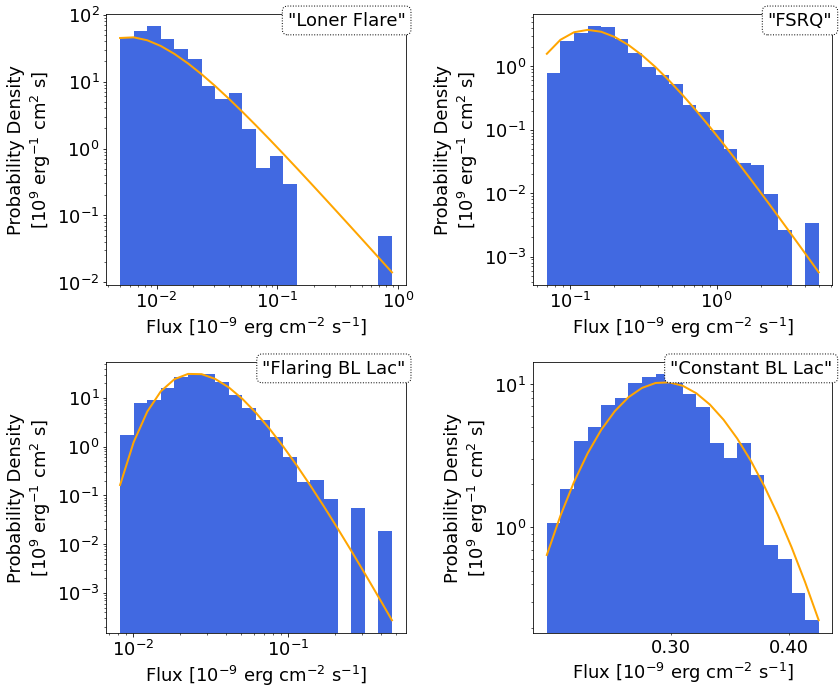

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, fluxes, param, source in zip(axes.flat, lcs, params, sources):
    __, bin_edges = np.histogram(np.log(fluxes[fluxes > 0]), bins=20)
    bins = np.exp(bin_edges)
    ax.hist(fluxes, bins=bins, density=True, color='royalblue')
    ax.plot(bins, stats.invgamma.pdf(bins, param[0], scale=param[1]), color='orange', linewidth=2)
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', linestyle=':')
    ax.text(1, 0.975, "\"{}\"".format(source[0]),
         horizontalalignment='right',
         verticalalignment='center',
         transform = ax.transAxes,
         bbox=props)
    ax.set_xlabel(r"Flux [$10^{-9}$ erg cm$^{-2}$ s$^{-1}$]")
    ax.set_ylabel("Probability Density\n[$10^{9}$ erg$^{-1}$ cm$^2$ s]")
    ax.set_xscale('log')
    ax.set_yscale('log')
    if source[0] == 'Constant BL Lac':
        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        ax.xaxis.set_minor_formatter(formatter)
    fig.tight_layout()
plt.savefig("flux_distributions.png")
plt.savefig("flux_distributions.pdf")

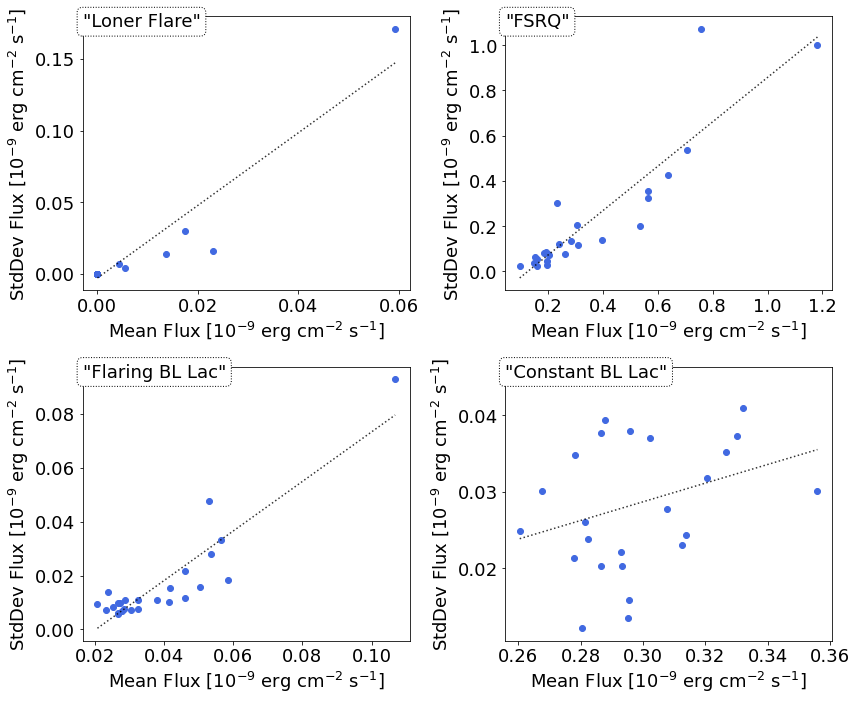

In [8]:
def f(x, m, b):
    return m*x + b

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
bin_size = 25
for ax, fluxes, param, source in zip(axes.flat, lcs, params, sources):
    means = np.mean(fluxes.reshape(-1, bin_size), axis=1)
    rms = np.std(fluxes.reshape(-1, bin_size), axis=1)
    ax.plot(means, rms, marker='o', linestyle='none', color='royalblue')
    x = np.linspace(np.min(means), np.max(means), 100)
    line_params, line_param_errs = optimize.curve_fit(f, means, rms)
    ax.plot(x, f(x, *line_params), linestyle=':', color='black', alpha=0.8)
    ax.set_xlabel(r"Mean Flux [$10^{-9}$ erg cm$^{-2}$ s$^{-1}$]")
    ax.set_ylabel(r"StdDev Flux [$10^{-9}$ erg cm$^{-2}$ s$^{-1}$]")
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', linestyle=':')
    ax.text(0, 0.98, "\"{}\"".format(source[0]),
         horizontalalignment='left',
         verticalalignment='center',
         transform = ax.transAxes,
         bbox=props)
    fig.tight_layout()
plt.savefig("flux_rms.png")
plt.savefig("flux_rms.pdf")

10.396723596343092
10.422382513348765
10.425947349898362
10.428451522338797


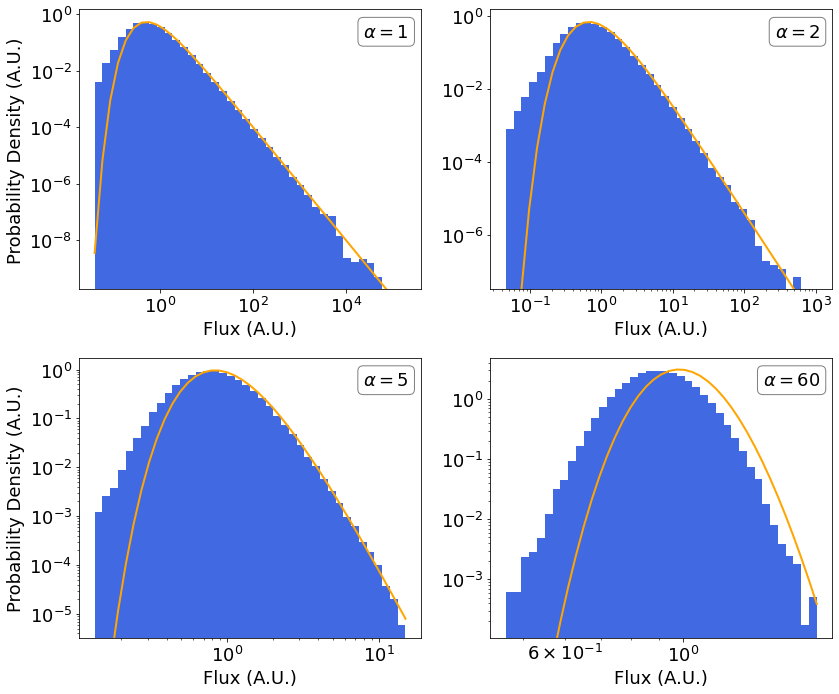

In [16]:
seed = 1234
alphas = [1, 2, 5, 60]
num_samples = 100000
sigma = 0.275

rng = np.random.default_rng(seed=seed)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (ax, alpha) in enumerate(zip(axes.flat, alphas)):
    # Let beta = alpha -> beta_burst = 1
    exp = rng.exponential(1, size=(num_samples, alpha))
    # Truncate at -3 to prevent negative deviations and +3 to preserve symmetry
    norm = stats.truncnorm.rvs(a=-3, b=3, loc=1, scale=sigma,
                               size=(num_samples, alpha), random_state=rng)
    print(np.max(norm)/np.min(norm))
    inverse_flux = np.mean(exp/norm, axis=1)
    flux = inverse_flux**-1

    __, bin_edges = np.histogram(np.log(flux), bins=40)
    bins = np.exp(bin_edges)
    ax.hist(flux, bins=bins, density=True, color='royalblue')
    
    # Ignore the overplotted distribution when autoscaling
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.autoscale_view()
    ax.set_autoscale_on(False)
    ax.plot(bins, stats.invgamma.pdf(bins, alpha, scale=alpha), color='orange', linewidth=2)
    
    props = dict(boxstyle='round', facecolor='white', edgecolor='gray', linestyle='-')
    ax.text(0.965, 0.92, r"$\alpha = {}$".format(alpha),
         horizontalalignment='right',
         verticalalignment='center',
         transform = ax.transAxes,
         bbox=props)
    ax.set_xlabel("Flux (A.U.)")
for i in range(2):
    axes[i, 0].set_ylabel("Probability Density (A.U.)")
fig.tight_layout()
plt.savefig("fluence_variability.png")
plt.savefig("fluence_variability.pdf")